In [1]:
import yfinance as yf
import keras.backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler ,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from keras.layers import LSTM,Dropout, BatchNormalization, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential
from keras.optimizer_v2.adam import Adam
from keras.optimizer_v2.rmsprop import RMSprop
import talib
tf.config.run_functions_eagerly(True)

In [2]:
# Get the data for the SPY ETF by specifying the stock ticker, start date, and end date
data = yf.download('HSI',"2019-09-28","2022-09-24")
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-10-09,25682.800781,25682.800781,25682.800781,25682.800781,25682.800781,0
2020-01-23,27909.099609,27909.099609,27909.099609,27909.099609,27909.099609,0
2020-01-24,27949.599609,27949.599609,27949.599609,27949.599609,27949.599609,0
2020-01-29,27160.599609,27160.599609,27160.599609,27160.599609,27160.599609,0
2020-01-30,26449.099609,26449.099609,26449.099609,26449.099609,26449.099609,0
...,...,...,...,...,...,...
2022-02-24,22901.599609,22901.599609,22901.599609,22901.599609,22901.599609,0
2022-02-25,22767.199219,22767.199219,22767.199219,22767.199219,22767.199219,0
2022-02-28,22713.000000,22713.000000,22713.000000,22713.000000,22713.000000,0


In [3]:
data['H-L'] = data['High'] - data['Low']
data['O-C'] = data['Close'] - data['Open']
# data=pd.merge(data,data["Close"].pct_change(),left_index=True,right_index=True)
data["% Change"]=data["Close"].pct_change(7)
data['7day MA'] = data['Close'].rolling(window = 7).mean()
data['14day MA'] = data['Close'].rolling(window = 14).mean()
data['21day MA'] = data['Close'].shift(1).rolling(window = 21).mean()
data['Std_dev']= data['Close'].shift(1).rolling(7).std()
# data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
# data['Williams %R'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 7)
data

,Open,High,Low,Close,Adj Close,Volume,H-L,O-C,% Change,7day MA,14day MA,21day MA,Std_dev
Date,,,,,,,,,,,,,
2019-10-09,25682.800781,25682.800781,25682.800781,25682.800781,25682.800781,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2020-01-23,27909.099609,27909.099609,27909.099609,27909.099609,27909.099609,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2020-01-24,27949.599609,27949.599609,27949.599609,27949.599609,27949.599609,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2020-01-29,27160.599609,27160.599609,27160.599609,27160.599609,27160.599609,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2020-01-30,26449.099609,26449.099609,26449.099609,26449.099609,26449.099609,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-24,22901.599609,22901.599609,22901.599609,22901.599609,22901.599609,0,0.0,0.0,-0.067395,24039.571429,24355.500000,24246.438244,500.270968
2022-02-25,22767.199219,22767.199219,22767.199219,22767.199219,22767.199219,0,0.0,0.0,-0.065221,23812.642857,24226.492746,24182.533482,697.683937
2022-02-28,22713.000000,22713.000000,22713.000000,22713.000000,22713.000000,0,0.0,0.0,-0.081148,23526.085658,24093.164202,24110.023903,824.529712


In [4]:
data.isnull().sum()

Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
H-L           0
O-C           0
% Change      7
7day MA       6
14day MA     13
21day MA     21
Std_dev       7
dtype: int64

In [5]:
data.dropna(inplace=True,axis=0)
data

,Open,High,Low,Close,Adj Close,Volume,H-L,O-C,% Change,7day MA,14day MA,21day MA,Std_dev
Date,,,,,,,,,,,,,
2020-02-25,26893.199219,26893.199219,26893.199219,26893.199219,26893.199219,0,0.0,0.0,-0.030177,27376.242746,27406.949916,27204.804688,338.433292
2020-02-26,26696.500000,26696.500000,26696.500000,26696.500000,26696.500000,0,0.0,0.0,-0.040233,27216.371373,27400.507115,27262.442708,386.316593
2020-02-27,26778.599609,26778.599609,26778.599609,26778.599609,26778.599609,0,0.0,0.0,-0.027301,27109.000000,27349.428571,27204.699870,405.287309
2020-02-28,26129.900391,26129.900391,26129.900391,26129.900391,26129.900391,0,0.0,0.0,-0.055175,26891.014230,27258.399972,27148.937965,407.840397
2020-03-02,26291.699219,26291.699219,26291.699219,26291.699219,26291.699219,0,0.0,0.0,-0.047720,26702.799944,27190.571289,27099.857050,469.933172
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-24,22901.599609,22901.599609,22901.599609,22901.599609,22901.599609,0,0.0,0.0,-0.067395,24039.571429,24355.500000,24246.438244,500.270968
2022-02-25,22767.199219,22767.199219,22767.199219,22767.199219,22767.199219,0,0.0,0.0,-0.065221,23812.642857,24226.492746,24182.533482,697.683937
2022-02-28,22713.000000,22713.000000,22713.000000,22713.000000,22713.000000,0,0.0,0.0,-0.081148,23526.085658,24093.164202,24110.023903,824.529712


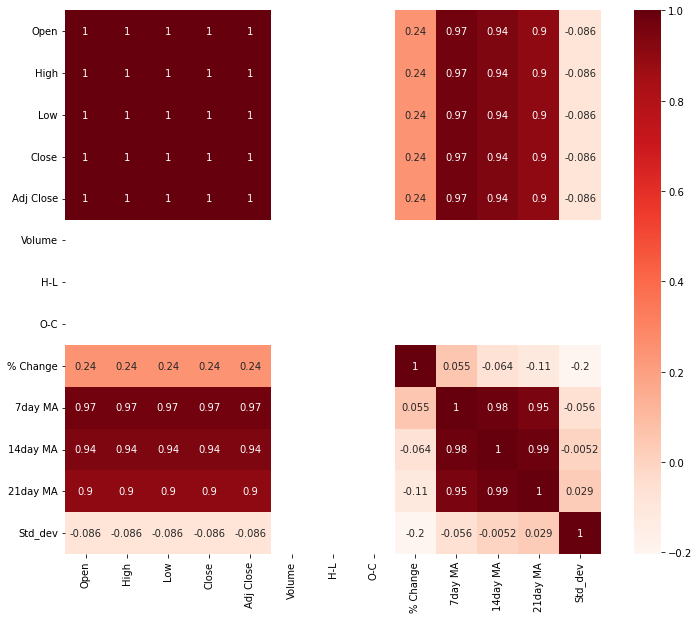

In [6]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [7]:
#Correlation with output variable
cor_target = abs(cor["Close"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

Open         1.000000
High         1.000000
Low          1.000000
Close        1.000000
Adj Close    1.000000
7day MA      0.972729
14day MA     0.942938
21day MA     0.903387
Name: Close, dtype: float64

In [8]:
# print(data[["RSI","Williams %R"]].corr())

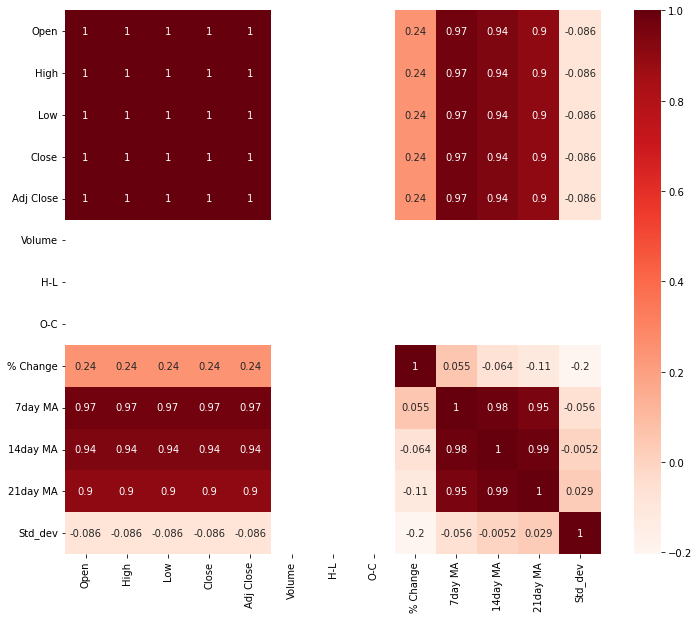

In [9]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
correlated_features = cor[cor>0.1].index.tolist()
corr_matrix = data[correlated_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap=plt.cm.Reds)
plt.show()

Best alpha using built-in LassoCV: 0.100000
Best score using built-in LassoCV: 1.000000
Lasso picked 8 variables and eliminated the other 3 variables


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_894/491588037.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=data.drop(["Close","Adj Close"],1)


Text(0.5, 1.0, 'Feature importance using Lasso Model')

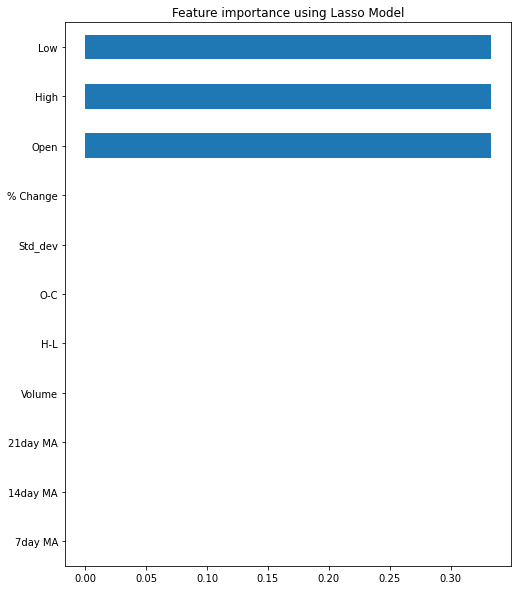

In [10]:
features = ["Open","High","Low","Close","Volume","H-L","O-C","7day MA","14day MA","21day MA","Std_dev"]
X=data.drop(["Close","Adj Close"],1)
y=data['Close']
reg = RidgeCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [11]:
data["Prediction"]=data['Adj Close'].shift(-1)
data.dropna(inplace=True)

In [12]:
def trim_dataset(mat, batch_size):
    
    #trims dataset to a size that's divisible by BATCH_SIZE
    no_of_rows_drop = mat.shape[0] % batch_size

    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat
    
def build_timeseries(mat, y_col_index):
    
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]

    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))

    print("Length of inputs", dim_0)
    print("shape:",mat.shape)
    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]

    print("length of time-series - inputs", x.shape)
    print("length of time-series - outputs", y.shape)

    return x, y

train_cols = ["Close","H-L","7day MA","14day MA","21day MA","Std_dev","Prediction"]
params = {
    "batch_size": 20,  # 20<16<10, 25 was a bust
    "epochs": 300,
    "lr": 0.0010000,
    "time_steps": 60
}
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]
df_train, df_test = train_test_split(data, train_size=0.8, test_size=0.2, shuffle=False)
print("Train--Test size", len(df_train), len(df_test))
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])
x_t, y_t = build_timeseries(x_train, 6)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
# print(x_test.shape)
print("Batch trimmed size", x_t.shape, y_t.shape)

Train--Test size 392 99
Length of inputs 332
shape: (392, 7)
length of time-series - inputs (332, 60, 7)
length of time-series - outputs (332,)
Batch trimmed size (320, 60, 7) (320,)


/opt/homebrew/Caskroom/miniforge/base/envs/fyp_new/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [13]:
'''Step 9 - Construct customized loss function for training'''
def custom_loss(y_true, y_pred):
    
    #extract the "next day's price" of tensor
    y_true_next = y_true[1:]
    y_pred_next = y_pred[1:]
    
    #extract the "today's price" of tensor
    y_true_tdy = y_true[:-1]
    y_pred_tdy = y_pred[:-1]
    
    print('Shape of y_pred_back -', y_pred_tdy.get_shape())
    
    #substract to get up/down movement of the two tensors
    y_true_diff = tf.subtract(y_true_next, y_true_tdy)
    y_pred_diff = tf.subtract(y_pred_next, y_pred_tdy)
        
    #create a standard tensor with zero value for comparison
    standard = tf.zeros_like(y_pred_diff)
    
    #compare with the standard; if true, UP; else DOWN
    y_true_move = tf.greater_equal(y_true_diff, standard)
    y_pred_move = tf.greater_equal(y_pred_diff, standard)
    y_true_move = tf.reshape(y_true_move, [-1])
    y_pred_move = tf.reshape(y_pred_move, [-1])
    

    #find indices where the directions are not the same
    condition = tf.not_equal(y_true_move, y_pred_move)
    indices = tf.where(condition)

    #move one position later
    ones = tf.ones_like(indices)
    indices = tf.add(indices, ones)
    indices = K.cast(indices, dtype='int32')
    
    
    #create a tensor to store directional loss and put it into custom loss output
    direction_loss = tf.Variable(tf.ones_like(y_pred), dtype='float32')
    updates = K.cast(tf.ones_like(indices), dtype='float32')
    alpha = 1000
    direction_loss = tf.compat.v1.scatter_nd_update(direction_loss, indices, alpha*updates)
    
    custom_loss = K.mean(tf.multiply(K.square(y_true - y_pred), direction_loss), axis=-1)
    
    return custom_loss

In [14]:
'''Step 10 - Build LSTM model'''

def create_lstm_model():
    lstm_model = Sequential()
    lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                        dropout=0.0, recurrent_dropout=0.0,
                        stateful=True, return_sequences=True
                       ))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(LSTM(60, dropout=0.0))
    lstm_model.add(Dropout(0.2))

    lstm_model.add(Dense(20))
    lstm_model.add(Dense(1))
        
    #compile the model
    optimizer = Adam(lr=params["lr"])
    lstm_model.compile(loss='mse', optimizer=optimizer)
  
    return lstm_model

lstm_model = None

In [15]:
# lstm_model = Sequential()
#     # (batch_size, timesteps, data_dim)
# lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
#                     dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
#                     kernel_initializer='random_uniform'))
# # lstm_model.add(Dropout(0.4))
# lstm_model.add(LSTM(60, dropout=0.0))
# # lstm_model.add(Dropout(0.4))
# lstm_model.add(Dense(20,activation='relu'))
# lstm_model.add(Dense(1,activation='sigmoid'))
# optimizer = RMSprop(learning_rate=params["lr"])
# # optimizer = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True)
# lstm_model.compile(loss=custom_loss, optimizer=optimizer)

In [26]:
x_temp, y_temp = build_timeseries(x_test, 6)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

Length of inputs 39
shape: (99, 7)
length of time-series - inputs (39, 60, 7)
length of time-series - outputs (39,)


In [27]:
lstm_model = create_lstm_model()
print(lstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (20, 60, 100)             43200     
                                                                 
 dropout_2 (Dropout)         (20, 60, 100)             0         
                                                                 
 lstm_3 (LSTM)               (20, 60)                  38640     
                                                                 
 dropout_3 (Dropout)         (20, 60)                  0         
                                                                 
 dense_2 (Dense)             (20, 20)                  1220      
                                                                 
 dense_3 (Dense)             (20, 1)                   21        
                                                                 
Total params: 83,081
Trainable params: 83,081
Non-trai

/opt/homebrew/Caskroom/miniforge/base/envs/fyp_new/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [28]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0.0001)
history = lstm_model.fit(x_t, y_t, epochs=params["epochs"], batch_size=BATCH_SIZE,
                        shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                        trim_dataset(y_val, BATCH_SIZE)),callbacks=[es])

Epoch 1/300
16/16 [==============================] - 1s 40ms/step - loss: 0.0247
Epoch 2/300
16/16 [==============================] - 1s 38ms/step - loss: 0.0351
Epoch 3/300
16/16 [==============================] - 1s 38ms/step - loss: 0.0531
Epoch 4/300
16/16 [==============================] - 1s 38ms/step - loss: 0.0166
Epoch 5/300
16/16 [==============================] - 1s 38ms/step - loss: 0.0107
Epoch 6/300
16/16 [==============================] - 1s 37ms/step - loss: 0.0118
Epoch 7/300
16/16 [==============================] - 1s 37ms/step - loss: 0.0091
Epoch 8/300
16/16 [==============================] - 1s 38ms/step - loss: 0.0079
Epoch 9/300
16/16 [==============================] - 1s 37ms/step - loss: 0.0084
Epoch 10/300
16/16 [==============================] - 1s 36ms/step - loss: 0.0086
Epoch 11/300
16/16 [==============================] - 1s 37ms/step - loss: 0.0080
Epoch 12/300
16/16 [==============================] - 1s 37ms/step - loss: 0.0072
Epoch 13/300
16/16 [=====

16/16 [==============================] - 1s 38ms/step - loss: 0.0027
Epoch 33/300
16/16 [==============================] - 1s 40ms/step - loss: 0.0031
Epoch 34/300
16/16 [==============================] - 1s 44ms/step - loss: 0.0048
Epoch 35/300
16/16 [==============================] - 1s 40ms/step - loss: 0.0074
Epoch 36/300
16/16 [==============================] - 1s 39ms/step - loss: 0.0060
Epoch 37/300
16/16 [==============================] - 1s 37ms/step - loss: 0.0082
Epoch 38/300
16/16 [==============================] - 1s 38ms/step - loss: 0.0078
Epoch 39/300
16/16 [==============================] - 1s 38ms/step - loss: 0.0150
Epoch 40/300
16/16 [==============================] - 1s 38ms/step - loss: 0.0087
Epoch 41/300
16/16 [==============================] - 1s 37ms/step - loss: 0.0048
Epoch 42/300
16/16 [==============================] - 1s 41ms/step - loss: 0.0033
Epoch 43/300
16/16 [==============================] - 1s 37ms/step - loss: 0.0033
Epoch 44/300
16/16 [=========

16/16 [==============================] - 1s 36ms/step - loss: 0.0048
Epoch 64/300
16/16 [==============================] - 1s 37ms/step - loss: 0.0035
Epoch 65/300
16/16 [==============================] - 1s 40ms/step - loss: 0.0023
Epoch 66/300
16/16 [==============================] - 1s 39ms/step - loss: 0.0026
Epoch 67/300
16/16 [==============================] - 1s 40ms/step - loss: 0.0027
Epoch 68/300
16/16 [==============================] - 1s 43ms/step - loss: 0.0049
Epoch 69/300
16/16 [==============================] - 1s 45ms/step - loss: 0.0031
Epoch 70/300
16/16 [==============================] - 1s 41ms/step - loss: 0.0030
Epoch 71/300
16/16 [==============================] - 1s 41ms/step - loss: 0.0025
Epoch 72/300
16/16 [==============================] - 1s 40ms/step - loss: 0.0045
Epoch 73/300
16/16 [==============================] - 1s 39ms/step - loss: 0.0046
Epoch 74/300
16/16 [==============================] - 1s 39ms/step - loss: 0.0022
Epoch 75/300
16/16 [=========

16/16 [==============================] - 1s 42ms/step - loss: 0.0027
Epoch 95/300
16/16 [==============================] - 1s 39ms/step - loss: 0.0038
Epoch 96/300
16/16 [==============================] - 1s 38ms/step - loss: 0.0021
Epoch 97/300
16/16 [==============================] - 1s 38ms/step - loss: 0.0028
Epoch 98/300
16/16 [==============================] - 1s 39ms/step - loss: 0.0021
Epoch 99/300
16/16 [==============================] - 1s 39ms/step - loss: 0.0039
Epoch 100/300
16/16 [==============================] - 1s 40ms/step - loss: 0.0031
Epoch 101/300
16/16 [==============================] - 1s 37ms/step - loss: 0.0018
Epoch 102/300
16/16 [==============================] - 1s 38ms/step - loss: 0.0019
Epoch 103/300
16/16 [==============================] - 1s 39ms/step - loss: 0.0015
Epoch 104/300
16/16 [==============================] - 1s 37ms/step - loss: 0.0023
Epoch 105/300
16/16 [==============================] - 1s 39ms/step - loss: 0.0019
Epoch 106/300
16/16 [==

Epoch 125/300
16/16 [==============================] - 1s 36ms/step - loss: 0.0020
Epoch 126/300
16/16 [==============================] - 1s 37ms/step - loss: 0.0022
Epoch 127/300
16/16 [==============================] - 1s 37ms/step - loss: 0.0019
Epoch 128/300
16/16 [==============================] - 1s 37ms/step - loss: 0.0030
Epoch 129/300
16/16 [==============================] - 1s 37ms/step - loss: 0.0034
Epoch 130/300
16/16 [==============================] - 1s 44ms/step - loss: 0.0018
Epoch 131/300
16/16 [==============================] - 1s 39ms/step - loss: 0.0028
Epoch 132/300
16/16 [==============================] - 1s 38ms/step - loss: 0.0020
Epoch 133/300
16/16 [==============================] - 1s 38ms/step - loss: 0.0039
Epoch 134/300
16/16 [==============================] - 1s 38ms/step - loss: 0.0033
Epoch 135/300
16/16 [==============================] - 1s 42ms/step - loss: 0.0018
Epoch 136/300
16/16 [==============================] - 1s 46ms/step - loss: 0.0021
Epoc

Epoch 156/300
16/16 [==============================] - 1s 38ms/step - loss: 0.0019
Epoch 157/300
16/16 [==============================] - 1s 37ms/step - loss: 0.0013
Epoch 158/300
16/16 [==============================] - 1s 39ms/step - loss: 0.0013
Epoch 159/300
16/16 [==============================] - 1s 39ms/step - loss: 0.0012
Epoch 160/300
16/16 [==============================] - 1s 39ms/step - loss: 0.0017
Epoch 161/300
16/16 [==============================] - 1s 39ms/step - loss: 0.0019
Epoch 162/300
16/16 [==============================] - 1s 38ms/step - loss: 0.0012
Epoch 163/300
16/16 [==============================] - 1s 39ms/step - loss: 0.0017
Epoch 164/300
16/16 [==============================] - 1s 37ms/step - loss: 0.0014
Epoch 165/300
16/16 [==============================] - 1s 41ms/step - loss: 0.0027
Epoch 166/300
16/16 [==============================] - 1s 40ms/step - loss: 0.0016
Epoch 167/300
16/16 [==============================] - 1s 37ms/step - loss: 0.0014
Epoc

Epoch 187/300
16/16 [==============================] - 1s 38ms/step - loss: 0.0017
Epoch 188/300
16/16 [==============================] - 1s 46ms/step - loss: 0.0012
Epoch 189/300
16/16 [==============================] - 1s 40ms/step - loss: 0.0027
Epoch 190/300
16/16 [==============================] - 1s 36ms/step - loss: 0.0017
Epoch 191/300
16/16 [==============================] - 1s 39ms/step - loss: 0.0011
Epoch 192/300
16/16 [==============================] - 1s 50ms/step - loss: 0.0012
Epoch 193/300
16/16 [==============================] - 1s 39ms/step - loss: 0.0014
Epoch 194/300
16/16 [==============================] - 1s 37ms/step - loss: 0.0017
Epoch 195/300
16/16 [==============================] - 1s 38ms/step - loss: 9.6224e-04
Epoch 196/300
16/16 [==============================] - 1s 39ms/step - loss: 0.0017
Epoch 197/300
16/16 [==============================] - 1s 41ms/step - loss: 0.0013
Epoch 198/300
16/16 [==============================] - 1s 37ms/step - loss: 0.0026


16/16 [==============================] - 1s 37ms/step - loss: 6.2162e-04
Epoch 218/300
16/16 [==============================] - 1s 38ms/step - loss: 0.0013
Epoch 219/300
16/16 [==============================] - 1s 36ms/step - loss: 0.0010
Epoch 220/300
16/16 [==============================] - 1s 40ms/step - loss: 0.0011
Epoch 221/300
16/16 [==============================] - 1s 38ms/step - loss: 0.0013
Epoch 222/300
16/16 [==============================] - 1s 37ms/step - loss: 0.0014
Epoch 223/300
16/16 [==============================] - 1s 37ms/step - loss: 0.0028
Epoch 224/300
16/16 [==============================] - 1s 40ms/step - loss: 0.0013
Epoch 225/300
16/16 [==============================] - 1s 37ms/step - loss: 0.0018
Epoch 226/300
16/16 [==============================] - 1s 38ms/step - loss: 0.0012
Epoch 227/300
16/16 [==============================] - 1s 39ms/step - loss: 0.0020
Epoch 228/300
16/16 [==============================] - 1s 36ms/step - loss: 0.0031
Epoch 229/300


16/16 [==============================] - 1s 39ms/step - loss: 0.0017
Epoch 249/300
16/16 [==============================] - 1s 37ms/step - loss: 0.0025
Epoch 250/300
16/16 [==============================] - 1s 38ms/step - loss: 0.0037
Epoch 251/300
16/16 [==============================] - 1s 37ms/step - loss: 0.0012
Epoch 252/300
16/16 [==============================] - 1s 37ms/step - loss: 0.0020
Epoch 253/300
16/16 [==============================] - 1s 40ms/step - loss: 8.4800e-04
Epoch 254/300
16/16 [==============================] - 1s 37ms/step - loss: 0.0025
Epoch 255/300
16/16 [==============================] - 1s 38ms/step - loss: 9.8515e-04
Epoch 256/300
16/16 [==============================] - 1s 38ms/step - loss: 0.0020
Epoch 257/300
16/16 [==============================] - 1s 37ms/step - loss: 8.8956e-04
Epoch 258/300
16/16 [==============================] - 1s 44ms/step - loss: 0.0025
Epoch 259/300
16/16 [==============================] - 1s 39ms/step - loss: 9.0284e-04
Ep

16/16 [==============================] - 1s 39ms/step - loss: 0.0011
Epoch 280/300
16/16 [==============================] - 1s 37ms/step - loss: 7.3500e-04
Epoch 281/300
16/16 [==============================] - 1s 37ms/step - loss: 0.0014
Epoch 282/300
16/16 [==============================] - 1s 39ms/step - loss: 7.3664e-04
Epoch 283/300
16/16 [==============================] - 1s 40ms/step - loss: 0.0013
Epoch 284/300
16/16 [==============================] - 1s 36ms/step - loss: 0.0012
Epoch 285/300
16/16 [==============================] - 1s 36ms/step - loss: 0.0016
Epoch 286/300
16/16 [==============================] - 1s 37ms/step - loss: 6.4409e-04
Epoch 287/300
16/16 [==============================] - 1s 37ms/step - loss: 7.7738e-04
Epoch 288/300
16/16 [==============================] - 1s 36ms/step - loss: 0.0013
Epoch 289/300
16/16 [==============================] - 1s 37ms/step - loss: 8.7930e-04
Epoch 290/300
16/16 [==============================] - 1s 37ms/step - loss: 0.001

KeyError: 'val_loss'

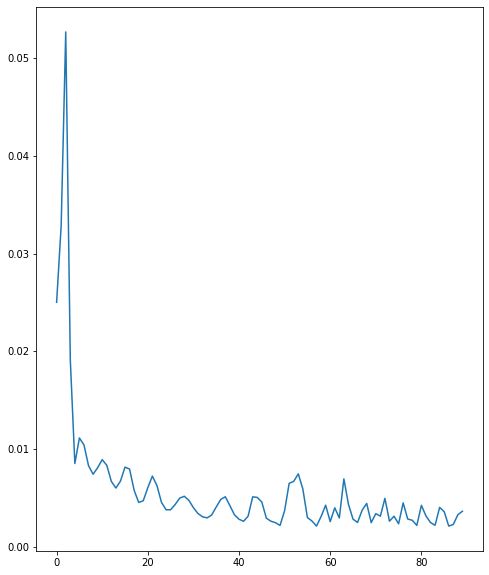

In [19]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [20]:
y_pred = lstm_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[6]) + min_max_scaler.data_min_[6]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[6]) + min_max_scaler.data_min_[6]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

ValueError: Unexpected result of `predict_function` (Empty batch_outputs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

In [ ]:
plt.figure()
plt.plot(y_pred_org,marker='*')
plt.plot(y_test_t_org,marker='.')
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')

In [21]:
mean_absolute_percentage_error(y_pred_org,y_test_t_org)*100

NameError: name 'y_pred_org' is not defined

In [22]:
mean_squared_error(y_pred_org,y_test_t_org)

NameError: name 'y_pred_org' is not defined

In [23]:
from sklearn.metrics import accuracy_score
y_pred_lstm_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_test_t)

print(y_pred_lstm_org[0:15])
print(y_test_t_org[0:15])

y_test_t_final = np.zeros((len(y_test_t_org)-1,))
y_pred_lstm_final = np.zeros((len(y_pred)-1,))

#convert prediction into binary output (up or down movement)
for i in range(len(y_pred_lstm_org)-1):
    if y_pred_lstm_org[i+1] >= y_pred_lstm_org[i]:
        y_pred_lstm_final[i] = 1
    else:
        y_pred_lstm_final[i] = 0
        
#convert prediction into binary output (up or down movement)
for i in range(len(y_test_t_org)-1):
    if y_test_t_org[i+1] >= y_test_t_org[i]:
        y_test_t_final[i] = 1
    else:
        y_test_t_final[i] = 0


# error_lstm = mean_absolute_error(y_test_t_final, y_pred_lstm_final)
# print("Error is", error_lstm, y_pred_lstm_final.shape, y_test_t_final.shape)
print(y_pred_lstm_final[0:15])
print(y_test_t_final[0:15])
print("Predicted direction accuracy (Up/down):")
print(accuracy_score(y_test_t_final,y_pred_lstm_final))

NameError: name 'y_pred' is not defined